In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")

In [ ]:
### Step 1: create model and calculate apparent performance metric of interest (P)
X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_CLINIC', 'PREV_REGION']]
y = CIP_data['Susceptible']
print(y.sum()/len(y))


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30) ## even doing trian/test split doesn't work...

neural_network_model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 1000 ,hidden_layer_sizes= 44, random_state=10)

neural_network_fit = neural_network_model.fit(X,y)
y_predict_nn = neural_network_fit.predict(X)

ROC_AUC_neural_network = metrics.roc_auc_score(y, y_predict_nn)

print(ROC_AUC_neural_network)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y, y_predict_nn)) ## but get model accuracy of 0.9470427693866846... so why is the ROC so low?  
## any why is this getting the same score as the random forest model?


In [ ]:

#### now try bootstrapping
#bootstrap data
n_iterations = 10
bootstrapped_stats = []

#1. Create model using all data and get ROC_AUC ("ROC_AUC_neural_network")
X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
y = CIP_data['Susceptible']

model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 1000 ,hidden_layer_sizes= 4, random_state=10)
model_fit = model.fit(X, y)
y_predict = model_fit.predict(X)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y, y_predict)

for i in range(n_iterations):
       #2. (A) Sample all individuals w/replacement
        sample = CIP_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
        X_sample = sample[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
        y_sample = sample['Susceptible']


       #  (B) Develop predictive model and find apparent performance
        model_fit = model.fit(X_sample, y_sample)
        y_sample_predict = model_fit.predict(X_sample)
        ROC_AUC_neural_network_bootstrap_sample_performance = metrics.roc_auc_score(y_sample, y_sample_predict) 

       #  (C) Performance of predictive model on original sample (i.e. original population, X)
        y_test_predict = model_fit.predict(X)
        ROC_AUC_neural_network_bootstrap_test_performance = metrics.roc_auc_score(y, y_test_predict) ## 0.756384214489288
      ### (D) Calculate optimisation by getting (B) - (D) 
        optimism = ROC_AUC_neural_network_bootstrap_sample_performance - ROC_AUC_neural_network_bootstrap_test_performance



        bootstrapped_stats.append(
        {
            'Sample ROC': ROC_AUC_neural_network_bootstrap_sample_performance,
            'Test ROC': ROC_AUC_neural_network_bootstrap_test_performance,
            'Optimisation': optimism
        }
       )


bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
print(bootstrapped_stats.head())
## Step 3: Get average optimization

average_optimisation = bootstrapped_stats["Optimisation"].mean() 

## Step 4: Get optimization-corrected performance

optimization_corrected_performance = ROC_AUC_neural_network_apparent - average_optimisation ##

print(optimization_corrected_performance)


In [ ]:
## Step 3: Get average optimization

average_optimisation_nn = bootstrapped_stats["Optimisation"].mean() 

## Step 4: Get optimization-corrected performance

optimization_corrected_performance_nn = ROC_AUC_neural_network - average_optimisation_nn ##

print(optimization_corrected_performance_nn)

## get CI 

Bootstrap_CI_nn = (1 - 0.25)*bootstrapped_stats["Optimisation"].quantile(q = 1)
Upper_bootstrap_CI = optimization_corrected_performance_nn + Bootstrap_CI_nn
Lower_bootstrap_CI = optimization_corrected_performance_nn - Bootstrap_CI_nn

print(Upper_bootstrap_CI, Lower_bootstrap_CI)

In [ ]:
## Try oversampling (randomly duplicates examples in the minority class). Very imbalanced dataset, as CIPRO + is a strong minority 
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy = 0.5)

X_over, y_over = oversample.fit_resample(X,y)
print(oversample)
neural_network_model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 1000 ,hidden_layer_sizes= 4, random_state=10)

neural_network_fit = neural_network_model.fit(X_over,y_over)
y_predict_nn = neural_network_fit.predict(X)

ROC_AUC_neural_network = metrics.roc_auc_score(y, y_predict_nn)

print(ROC_AUC_neural_network)

In [86]:
### Try hyperparameter tuning with random oversampling 
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
space = dict()
space['activation'] = ['tanh', 'relu']
space['solver'] = ['sdg', 'adam', 'lbfgs']
space['alpha'] = np.logspace(-1, 1, 10)
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(4), (6),(8), (12)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)


model = MLPClassifier(random_state=10, max_iter = 1000)

X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_CLINIC', 'PREV_REGION']]
y = CIP_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5)
X, y = oversample.fit_resample(X,y)
model_fit = model.fit(X, y)

search = RandomizedSearchCV(model, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: Conv

Best Score: 0.8019328927793805
Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 1.291549665014884, 'activation': 'relu'}


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [89]:
#### Try bootstrapping with oversampling and hyperparameters
#Best Score: 0.8019328927793805
#Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 1.291549665014884, 'activation': 'relu'}
#bootstrap data
n_iterations = 100
bootstrapped_stats = []

#1. Create model using all data and get ROC_AUC ("ROC_AUC_neural_network")
X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
y = CIP_data['Susceptible']
X, y = oversample.fit_resample(X,y)
model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#model = MLPClassifier(solver = 'lbfgs', activation = 'relu', max_iter = 1000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

model_fit = model.fit(X, y)
y_predict = model_fit.predict(X)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y, y_predict)

for i in range(n_iterations):
       #2. (A) Sample all individuals w/replacement
        sample = CIP_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
        X_sample = sample[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
        y_sample = sample['Susceptible']
        X_sample, y_sample = oversample.fit_resample(X_sample,y_sample)


       #  (B) Develop predictive model and find apparent performance
        model_fit = model.fit(X_sample, y_sample)
        y_sample_predict = model_fit.predict(X_sample)
        ROC_AUC_neural_network_bootstrap_sample_performance = metrics.roc_auc_score(y_sample, y_sample_predict) 

       #  (C) Performance of predictive model on original sample (i.e. original population, X)
        y_test_predict = model_fit.predict(X)
        ROC_AUC_neural_network_bootstrap_test_performance = metrics.roc_auc_score(y, y_test_predict) ## 0.756384214489288
      ### (D) Calculate optimisation by getting (B) - (D) 
        optimism = ROC_AUC_neural_network_bootstrap_sample_performance - ROC_AUC_neural_network_bootstrap_test_performance



        bootstrapped_stats.append(
        {
            'Sample ROC': ROC_AUC_neural_network_bootstrap_sample_performance,
            'Test ROC': ROC_AUC_neural_network_bootstrap_test_performance,
            'Optimisation': optimism
        }
       )


bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
print(bootstrapped_stats.head())
## Step 3: Get average optimization

average_optimisation = bootstrapped_stats["Optimisation"].mean() 

## Step 4: Get optimization-corrected performance

optimization_corrected_performance = ROC_AUC_neural_network_apparent - average_optimisation ##

print(optimization_corrected_performance)


Bootstrap_CI_nn = (1 - 0.025)*bootstrapped_stats["Optimisation"].quantile(q = 1)
Upper_bootstrap_CI = optimization_corrected_performance + Bootstrap_CI_nn
Lower_bootstrap_CI = optimization_corrected_performance - Bootstrap_CI_nn


print(Upper_bootstrap_CI, Lower_bootstrap_CI)


KeyboardInterrupt: 

In [90]:
#### Try bootstrapping with oversampling and hyperparameters and threshold 
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import confusion_matrix

#bootstrap data
n_iterations = 10
bootstrapped_stats = []

#1. Create model using all data and get ROC_AUC ("ROC_AUC_neural_network")
X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
y = CIP_data['Susceptible']
X, y = oversample.fit_resample(X,y)
model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 1000 ,hidden_layer_sizes= 12, random_state=10, learning_rate = 'adaptive' )
model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )

model_fit = model.fit(X, y)
y_predict = model_fit.predict(X)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y, y_predict)

##threshold
threshold = 0.5
for i in range(n_iterations):
       #2. (A) Sample all individuals w/replacement
        sample = CIP_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
        X_sample = sample[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
        y_sample = sample['Susceptible']
        X_sample, y_sample = oversample.fit_resample(X_sample,y_sample)


       #  (B) Develop predictive model and find apparent performance
        model_fit = model.fit(X_sample, y_sample)
        y_sample_predict = model_fit.predict(X_sample)
        y_sample_predict_prob = model_fit.predict_proba(X_sample)

        ROC_AUC_neural_network_bootstrap_sample_performance = metrics.roc_auc_score(y_sample, y_sample_predict) 

       #  (C) Performance of predictive model on original sample (i.e. original population, X)
        y_test_predict = model_fit.predict(X)
        y_test_predict_prob = model_fit.predict_proba(X)

        ROC_AUC_neural_network_bootstrap_test_performance = metrics.roc_auc_score(y, y_test_predict) ## 0.756384214489288
      ### (D) Calculate optimisation by getting (B) - (D) 
        optimism = ROC_AUC_neural_network_bootstrap_sample_performance - ROC_AUC_neural_network_bootstrap_test_performance
     
      ### (i) Calculate sensitivity and specificity 
        if threshold is not None:
           y_sample_predict = np.where(y_sample_predict_prob[:, 1] > threshold, 1, 0)
           y_test_predict = np.where(y_test_predict_prob[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y, y_pred=y_test_predict).ravel()
        tn_sample, fp_sample, fn_sample, tp_sample = confusion_matrix(y_true=y_sample, y_pred=y_sample_predict).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_sample = tp_sample/ (tp_sample + fn_sample)
        specificity_sample = tn_sample / (tn_sample + fp_sample)

        fpr_test, tpr_test, threshold_test = roc_curve(y, y_test_predict_prob[:, 1], drop_intermediate=False)
        fpr_sample, tpr_sample, threshold_sample = roc_curve(y_sample, y_sample_predict_prob[:, 1], drop_intermediate=False)


        #ROC_AUC_nn_test = roc_auc = auc(fpr_test, tpr_test)
        #ROC_AUC_nn_sample = roc_auc = auc(fpr_sample, tpr_sample)


        bootstrapped_stats.append(
        {
            'Sample ROC': ROC_AUC_neural_network_bootstrap_sample_performance,
            'Test ROC': ROC_AUC_neural_network_bootstrap_test_performance,
            'Optimisation': optimism,
            'Sample Sensitivity': sensitivity_sample,
            'Sample Specificity': specificity_sample,
            'Test Sensitivity': sensitivity_test,
            'Test Specificity': specificity_test,
            'Sample FPR': fpr_sample,
            'Sample TPR': tpr_sample,
            'Test FPR': fpr_test,
            'Test TPR': tpr_test
        }
       )


bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
print(bootstrapped_stats.head())
## Step 3: Get average optimization

average_optimisation = bootstrapped_stats["Optimisation"].mean() 

## Step 4: Get optimization-corrected performance

optimization_corrected_performance = ROC_AUC_neural_network_apparent - average_optimisation ##

print(optimization_corrected_performance)


Bootstrap_CI_nn = (1 - 0.025)*bootstrapped_stats["Optimisation"].quantile(q = 1)
Upper_bootstrap_CI = optimization_corrected_performance + Bootstrap_CI_nn
Lower_bootstrap_CI = optimization_corrected_performance - Bootstrap_CI_nn


print(Upper_bootstrap_CI, Lower_bootstrap_CI)

#### sensitivity 

KeyboardInterrupt: 

In [99]:
#### Response of sensitivity and specificity to threshold

from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import confusion_matrix

#bootstrap data
n_iterations = 100
bootstrapped_stats = []

#1. Create model using all data and get ROC_AUC ("ROC_AUC_neural_network")

model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 2000 ,hidden_layer_sizes= 12, random_state=10, learning_rate = 'adaptive' )
model = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )


##threshold
threshold_seq = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
sensitivity_sample_table = []
specificity_sample_table = []
sensitivity_test_table = []
specificity_test_table = []
sensitivity_test_table_975 = []
sensitivity_test_table_025 = []
specificity_test_table_975 = []
specificity_test_table_025 = []
for threshold in threshold_seq:
  print(threshold)
  bootstrapped_stats = []
  #1. Create model using all data and get ROC_AUC ("ROC_AUC_neural_network") - need to do this for each threshold

  X = CIP_data[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
  y = CIP_data['Susceptible']
  X, y = oversample.fit_resample(X,y)
  model_fit = model.fit(X, y)
  y_predict = model_fit.predict(X)
  y_predict_proba = model_fit.predict_proba(X)
 
  y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)
  tn_apparent , fp_apparent, fn_apparent, tp_apparent = confusion_matrix(y_true=y, y_pred=y_predict).ravel()

  sensitivity_apparent = tp_apparent / (tp_apparent  + fn_apparent )
  specificity_apparent  = tn_apparent / (tn_apparent + fp_apparent )
  for i in range(n_iterations):
        #2. (A) Sample all individuals w/replacement
          sample = CIP_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          X_sample = sample[['MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC']]
          y_sample = sample['Susceptible']
          X_sample, y_sample = oversample.fit_resample(X_sample,y_sample)


        #  (B) Develop predictive model and find apparent performance
          model_fit = model.fit(X_sample, y_sample)
          y_sample_predict = model_fit.predict(X_sample)
          y_sample_predict_prob = model_fit.predict_proba(X_sample)

          ROC_AUC_neural_network_bootstrap_sample_performance = metrics.roc_auc_score(y_sample, y_sample_predict) 

        #  (C) Performance of predictive model on original sample (i.e. original population, X)
          y_test_predict = model_fit.predict(X)
          y_test_predict_prob = model_fit.predict_proba(X)

          ROC_AUC_neural_network_bootstrap_test_performance = metrics.roc_auc_score(y, y_test_predict) ## 0.756384214489288
        ### (D) Calculate optimisation by getting (B) - (D) 
          optimism = ROC_AUC_neural_network_bootstrap_sample_performance - ROC_AUC_neural_network_bootstrap_test_performance
      
        ### (i) Calculate sensitivity and specificity 
          
          y_sample_predict = np.where(y_sample_predict_prob[:, 1] > threshold, 1, 0)
          y_test_predict = np.where(y_test_predict_prob[:, 1] > threshold, 1, 0)

          tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y, y_pred=y_test_predict).ravel()
          tn_sample, fp_sample, fn_sample, tp_sample = confusion_matrix(y_true=y_sample, y_pred=y_sample_predict).ravel()

          sensitivity_test = tp_test / (tp_test + fn_test)
          specificity_test = tn_test / (tn_test + fp_test)

          sensitivity_sample = tp_sample/ (tp_sample + fn_sample)
          specificity_sample = tn_sample / (tn_sample + fp_sample)

          fpr_test, tpr_test, threshold_test = roc_curve(y, y_test_predict_prob[:, 1], drop_intermediate=False)
          fpr_sample, tpr_sample, threshold_sample = roc_curve(y_sample, y_sample_predict_prob[:, 1], drop_intermediate=False)
          
          sensitivity_optimism = sensitivity_sample - sensitivity_test
          specificity_optimism = specificity_sample - specificity_test

          bootstrapped_stats.append(
        {
            'Sample ROC': ROC_AUC_neural_network_bootstrap_sample_performance,
            'Test ROC': ROC_AUC_neural_network_bootstrap_test_performance,
            'Optimisation': optimism,
            'Sample Sensitivity': sensitivity_sample,
            'Sample Specificity': specificity_sample,
            'Test Sensitivity': sensitivity_test,
            'Test Specificity': specificity_test,
            'Sensitivity Optimisation': sensitivity_optimism,
            'Specificity Optimisation': specificity_optimism,
            'Sample FPR': fpr_sample,
            'Sample TPR': tpr_sample,
            'Test FPR': fpr_test,
            'Test TPR': tpr_test
        })
  bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
  specificity_sample_optimism = bootstrapped_stats["Specificity Optimisation"].mean() 
  sensitivity_sample_optimism = bootstrapped_stats["Sensitivity Optimisation"].mean() 

  specificity_sample_optimised = specificity_apparent - specificity_sample_optimism ##
  sensitivity_sample_optimised = sensitivity_apparent - sensitivity_sample_optimism ##

  specificity_sample_95CI_lower = specificity_sample_optimised - bootstrapped_stats["Specificity Optimisation"].quantile(0.025)
  specificity_sample_95CI_upper = specificity_sample_optimised + bootstrapped_stats["Specificity Optimisation"].quantile(0.975)

  sensitivity_sample_95CI_lower= sensitivity_sample_optimised - bootstrapped_stats["Sensitivity Optimisation"].quantile(0.025)
  sensitivity_sample_95CI_upper = sensitivity_sample_optimised + bootstrapped_stats["Sensitivity Optimisation"].quantile(0.975)

  #sensitivity_sample_table.append(sensitivity_sample_optimised)
  #specificity_sample_table.append(specificity_sample_optimised)
  sensitivity_test_table.append(sensitivity_sample_optimised)
  specificity_test_table.append(specificity_sample_optimised)
  sensitivity_test_table_975.append(sensitivity_sample_95CI_upper)
  sensitivity_test_table_025.append(sensitivity_sample_95CI_lower)
  specificity_test_table_975.append(specificity_sample_95CI_upper)
  specificity_test_table_025.append(specificity_sample_95CI_lower)

          
        


0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55


In [98]:
#print(specificity_test_table)
#print(sensitivity_test_table)
print(specificity_test_table)

print(specificity_test_table_975)

#specificity_test_table = pd.DataFrame(specificity_test_table)
#sensitivity_test_table = pd.DataFrame(sensitivity_test_table)
#specificity_test_table.haed()

[0.0, -2.4923882756036473e-05, 0.00010145885042908893, 0.057477410341451415, 0.3291139534420123, 0.6091562469954745, 0.7513505544673343, 0.8538751932032604, 0.9384390510563354, 0.9773692248644632, 1.0]
[0.0, 0.0001844692550408062, 0.0009339891318192366, 0.061514217039305714, 0.3389041253244375, 0.6154834450572753, 0.7581003245053937, 0.8585835105032786, 0.9448817913121453, 0.9800770162605797, 1.0]


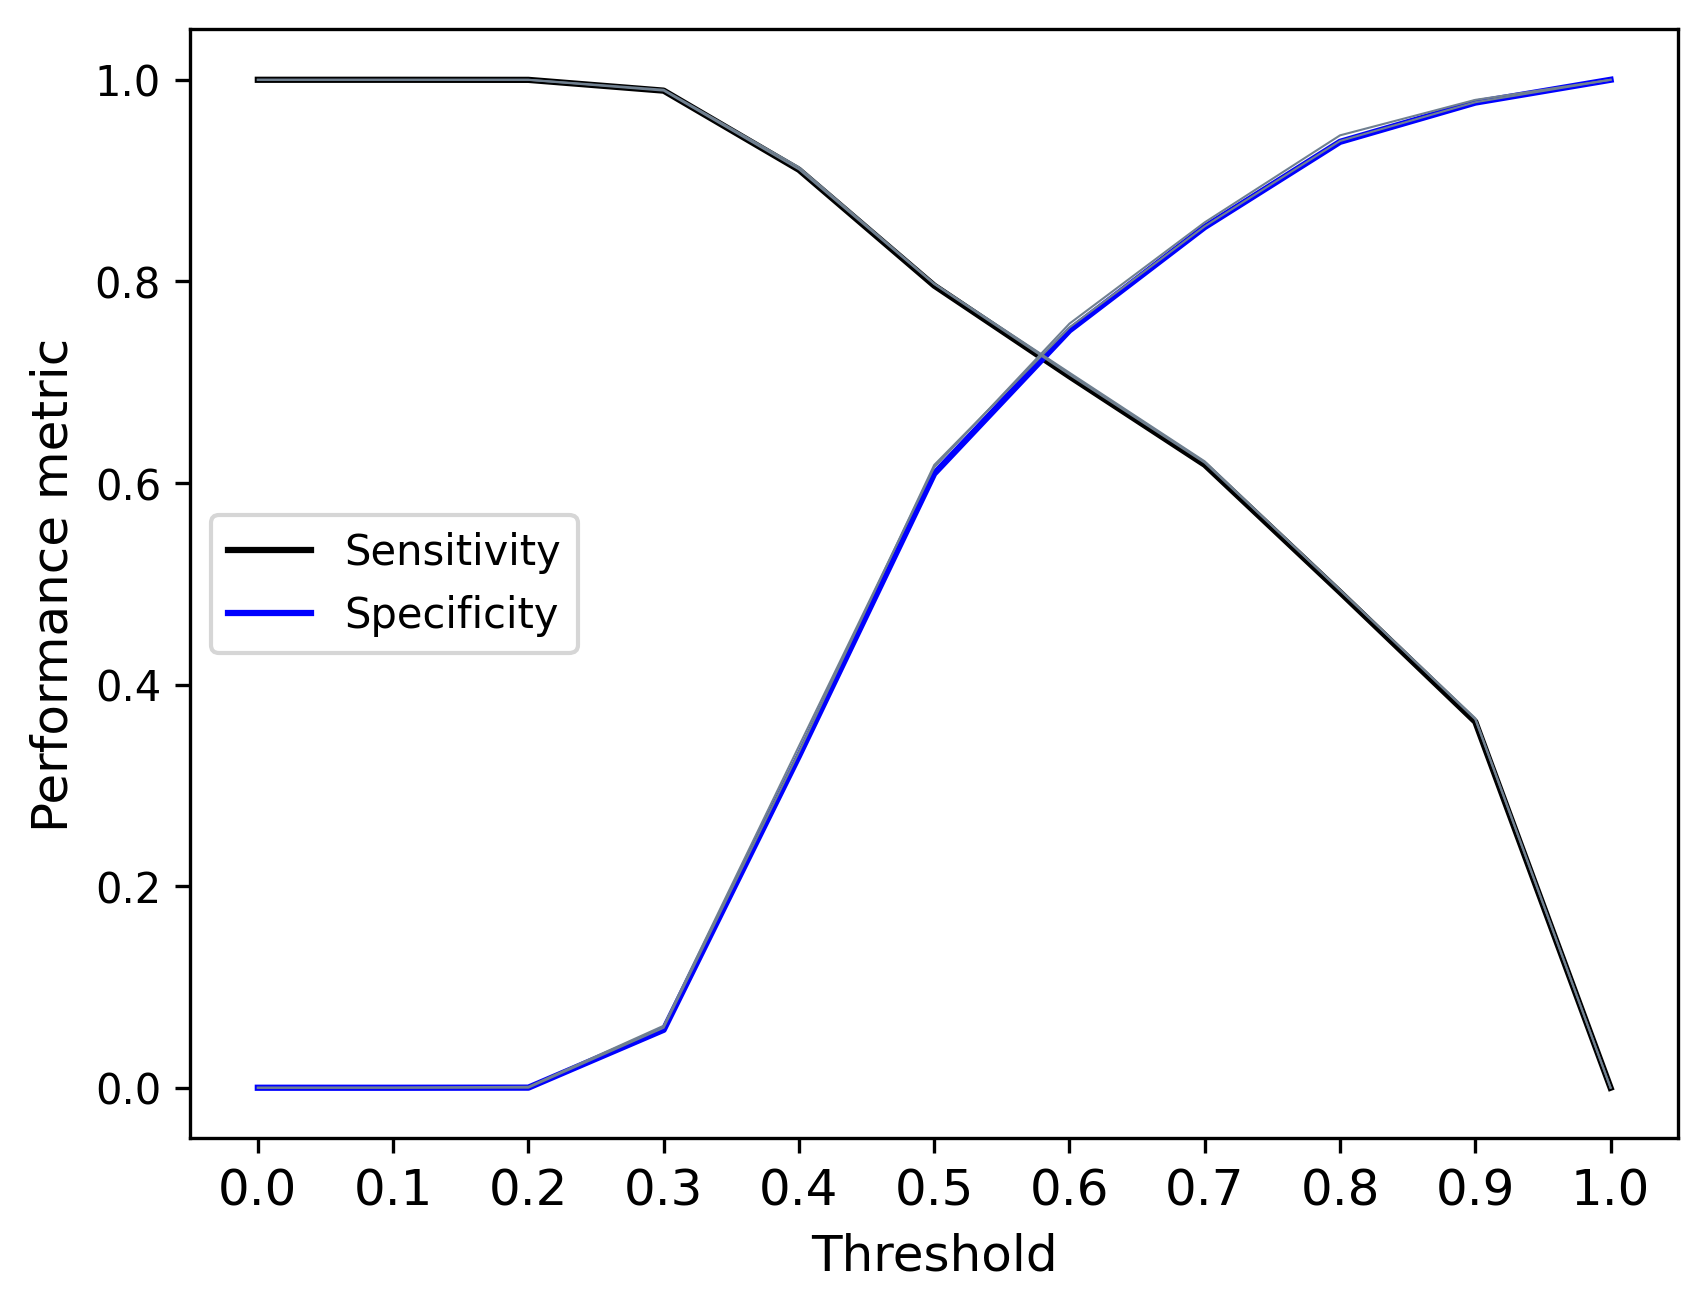

In [93]:
sensitivity_test_df = pd.DataFrame(sensitivity_test_table)
sensitivity_test_df_975 = pd.DataFrame(sensitivity_test_table_975)
sensitivity_test_df_025 = pd.DataFrame(sensitivity_test_table_025)

specificity_test_df_975 = pd.DataFrame(specificity_test_table_975)
specificity_test_df_025 = pd.DataFrame(specificity_test_table_025)

threshold_seq = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.plot(threshold_seq, sensitivity_test_table, color = "black", label = "Sensitivity")
plt.plot(threshold_seq, specificity_test_table, color = "blue", label = "Specificity")
#error
plt.plot(threshold_seq, sensitivity_test_df_975, color = "slategrey", label = "", linewidth=0.5)
plt.plot(threshold_seq, sensitivity_test_df_025, color = "slategrey", label = "", linewidth=0.5)
plt.plot(threshold_seq, specificity_test_df_975, color = "slategrey", label = "", linewidth=0.5)
plt.plot(threshold_seq, specificity_test_df_025, color = "slategrey", label = "", linewidth=0.5)



#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Performance metric", fontsize=12)
plt.xticks(threshold_seq, fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()